In [1]:
# 1. Importing necessary libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from autocorrect import spell
import matplotlib.pyplot as plt
from math import log, sqrt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import numpy as np
import pandas as pd
import re

In [2]:
# 2. Loading the Dataset
messages = pd.read_csv('spam.csv', encoding = 'latin-1')
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# 3.a. Dataset Pre-Processing
# removing unwanted columns
messages = messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
messages.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# renaming columns and converting to numerical form
messages = messages.rename(columns={'v1':'label', 'v2':'message'})
print(messages.label.value_counts())
messages['label'] = messages.label.map({'ham':0, 'spam':1})
messages.head()

ham     4825
spam     747
Name: label, dtype: int64


,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# 4. Visualizing the Dataset

# basic description of the dataset
print('Dataset Description : ', messages.groupby('label').describe(),'\n')
# length of the messages 
messages['start_length'] = messages['message'].map(lambda msg: len(msg))
print(messages.head())

Dataset Description :        message                                                               
        count unique                                                top freq
label                                                                       
0        4825   4516                             Sorry, I'll call later   30
1         747    653  Please call our customer service representativ...    4 

   label                                            message  start_length
0      0  Go until jurong point, crazy.. Available only ...           111
1      0                      Ok lar... Joking wif u oni...            29
2      1  Free entry in 2 a wkly comp to win FA Cup fina...           155
3      0  U dun say so early hor... U c already then say...            49
4      0  Nah I don't think he goes to usf, he lives aro...            61


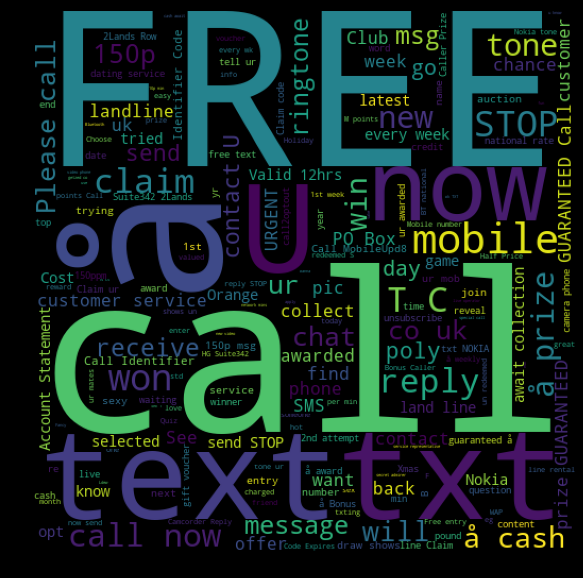

In [6]:
# spam messages word cloud
spamWords = ''.join(list(messages[messages['label']==1]['message']))
spamWordCloud = WordCloud(width=512, height=512).generate(spamWords)
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(spamWordCloud)
plt.show()

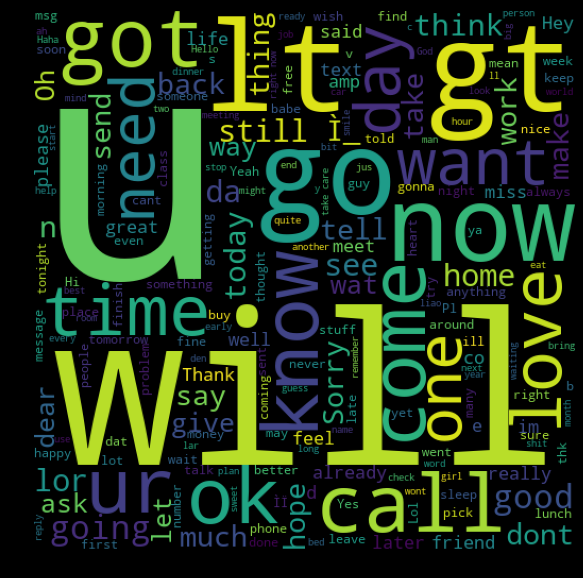

In [7]:
# ham messages word cloud
hamWords = ''.join(list(messages[messages['label']==0]['message']))
hamWordCloud = WordCloud(width=512, height=512).generate(hamWords)
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(hamWordCloud)
plt.show()

In [8]:
# 3.b. Dataset Preprocessing prep for training
def preprocessing(dataset):
    lbls = dataset['label']
    msgs = dataset['message']

    processedMessages = msgs.str.replace(r'[^A-Za-z\s\w\d\s+]', '')

    processedMessages = processedMessages.str.lower()

    stop_words = stopwords.words('english')
    processedMessages = processedMessages.apply(lambda words: ' '.join(word for word in words.split() if word not in set(stop_words)))

    stemmer = PorterStemmer()
    processedMessages = processedMessages.apply(lambda words: ' '.join(stemmer.stem(word) for word in words.split()))
    
    return pd.concat([lbls, processedMessages], axis=1)

processedMessages = preprocessing(messages)

processedMessages['after_length'] = processedMessages['message'].map(lambda msg: len(msg))
print(processedMessages.head())

#example = pd.DataFrame({'label':[0], 'message': ["""  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """]})
example = pd.DataFrame({'label':[1], 'message': ["Free entry in 2 a wkly comp to win FA Cup final"]})
processedExample = preprocessing(example)
print(processedExample)

<ipython-input-8-116cdd0739a2>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  processedMessages = msgs.str.replace(r'[^A-Za-z\s\w\d\s+]', '')


   label                                            message  after_length
0      0  go jurong point crazi avail bugi n great world...            76
1      0                              ok lar joke wif u oni            21
2      1  free entri 2 wkli comp win fa cup final tkt 21...           131
3      0                u dun say earli hor u c alreadi say            35
4      0          nah dont think goe usf live around though            41
   label                                  message
0      1  free entri 2 wkli comp win fa cup final


<ipython-input-8-116cdd0739a2>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  processedMessages = msgs.str.replace(r'[^A-Za-z\s\w\d\s+]', '')


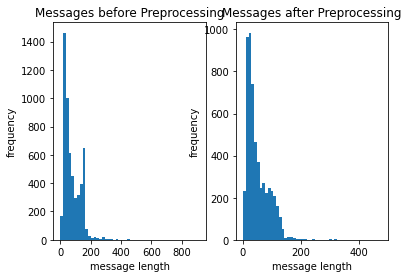

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

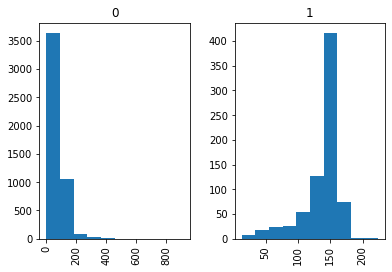

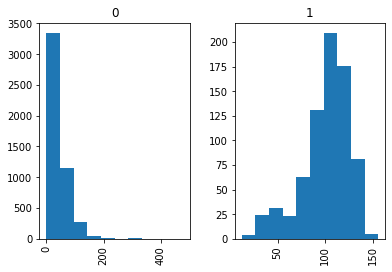

In [9]:
# Message Lengths comparison before and after dataset prepeocessing
figure, ax = plt.subplots(1,2)
ax[0].hist(messages['start_length'], bins=50)
ax[0].set_title('Messages before Preprocessing')
ax[0].set_xlabel('message length')
ax[0].set_ylabel('frequency')

ax[1].hist(processedMessages['after_length'], bins=50)
ax[1].set_title('Messages after Preprocessing')
ax[1].set_xlabel('message length')
ax[1].set_ylabel('frequency')
plt.show()

# based on message length and label
messages['start_length'].hist(by = messages['label'])
processedMessages['after_length'].hist(by = processedMessages['label'])

In [10]:
# 5. Splitting dataset into Training and Testing 75:25 
print(processedMessages.head())
trainMessages, testMessages, trainLabels, testLabels = train_test_split(
    processedMessages["message"], processedMessages["label"], test_size = 0.25, random_state = 10
)
print(trainMessages.shape)
print(testMessages.shape)
print(trainLabels.shape)
print(testLabels.shape)

   label                                            message  after_length
0      0  go jurong point crazi avail bugi n great world...            76
1      0                              ok lar joke wif u oni            21
2      1  free entri 2 wkli comp win fa cup final tkt 21...           131
3      0                u dun say earli hor u c alreadi say            35
4      0          nah dont think goe usf live around though            41
(4179,)
(1393,)
(4179,)
(1393,)


In [11]:
# 6. Classifier
vectorize = CountVectorizer(stop_words='english')
vectorize.fit(trainMessages)

trainMessagesDF = vectorize.transform(trainMessages)
testMessagesDF = vectorize.transform(testMessages)
exampleMessageDF = vectorize.transform(processedExample['message'])

In [12]:
# multinomial naive bayes classifier
mnbModel = MultinomialNB()
%time mnbModel.fit(trainMessagesDF,trainLabels)

mnbPrediction = mnbModel.predict(testMessagesDF)

print('Multinomial Naive Bayes F1 Score :', metrics.f1_score(testLabels, mnbPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, mnbPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

CPU times: user 5.19 ms, sys: 2.66 ms, total: 7.85 ms
Wall time: 5.6 ms
Multinomial Naive Bayes F1 Score : 0.9424083769633508


predicted     
                 spam  ham
actual spam      1191   10
       ham         12  180

In [13]:
 print('Multinomial Naive Bayes - Classification Report \n', classification_report(testLabels, mnbPrediction))

Multinomial Naive Bayes - Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1201
           1       0.95      0.94      0.94       192

    accuracy                           0.98      1393
   macro avg       0.97      0.96      0.97      1393
weighted avg       0.98      0.98      0.98      1393



In [14]:
# bernoulli naive bayes classifier
bnbModel = BernoulliNB()
bnbModel.fit(trainMessagesDF,trainLabels)

bnbPrediction = bnbModel.predict(testMessagesDF)

print('Bernoulli Naive Bayes F1 Score :', metrics.f1_score(testLabels, bnbPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, bnbPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

Bernoulli Naive Bayes F1 Score : 0.8771929824561403


predicted     
                 spam  ham
actual spam      1201    0
       ham         42  150

In [15]:
 print('Bernoulli Naive Bayes - Classification Report \n', classification_report(testLabels, bnbPrediction))

Bernoulli Naive Bayes - Classification Report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1201
           1       1.00      0.78      0.88       192

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [16]:
# linear svc classifier
linsvcModel = LinearSVC()
linsvcModel.fit(trainMessagesDF,trainLabels)

linsvcPrediction = linsvcModel.predict(testMessagesDF)

print('Linear SVC F1 Score :', metrics.f1_score(testLabels, linsvcPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, linsvcPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

Linear SVC F1 Score : 0.9362880886426592


predicted     
                 spam  ham
actual spam      1201    0
       ham         23  169

In [17]:
 print('Linear SVC - Classification Report \n', classification_report(testLabels, linsvcPrediction))

Linear SVC - Classification Report 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1201
           1       1.00      0.88      0.94       192

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [18]:
# svc classifier
svcModel = SVC(kernel='rbf')
svcModel.fit(trainMessagesDF,trainLabels)

svcPrediction = svcModel.predict(testMessagesDF)

print('SVC (rbf Kernel) F1 Score :', metrics.f1_score(testLabels, svcPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, svcPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

SVC (rbf Kernel) F1 Score : 0.9028571428571429


predicted     
                 spam  ham
actual spam      1201    0
       ham         34  158

In [19]:
 print('SVC (rbf Kernel) - Classification Report \n', classification_report(testLabels, svcPrediction))

SVC (rbf Kernel) - Classification Report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1201
           1       1.00      0.82      0.90       192

    accuracy                           0.98      1393
   macro avg       0.99      0.91      0.94      1393
weighted avg       0.98      0.98      0.97      1393



In [20]:
# logistic regression classifier
logRegModel = LogisticRegression()
logRegModel.fit(trainMessagesDF, trainLabels)

logRegPrediction = logRegModel.predict(testMessagesDF)

print('Logistic Regression F1 Score :', metrics.f1_score(testLabels, logRegPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, logRegPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

Logistic Regression F1 Score : 0.9213483146067416


predicted     
                 spam  ham
actual spam      1201    0
       ham         28  164

In [21]:
 print('Logistic Regression - Classification Report \n', classification_report(testLabels, logRegPrediction))

Logistic Regression - Classification Report 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1201
           1       1.00      0.85      0.92       192

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



In [22]:
# decision tree classifier
dtcModel = DecisionTreeClassifier()
dtcModel.fit(trainMessagesDF, trainLabels)

dtcPrediction = dtcModel.predict(testMessagesDF)

print('Decision Tree F1 Score :', metrics.f1_score(testLabels, dtcPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, dtcPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

Decision Tree F1 Score : 0.8767123287671232


predicted     
                 spam  ham
actual spam      1188   13
       ham         32  160

In [23]:
 print('Decision Tree - Classification Report \n', classification_report(testLabels, dtcPrediction))

Decision Tree - Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1201
           1       0.92      0.83      0.88       192

    accuracy                           0.97      1393
   macro avg       0.95      0.91      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [24]:
# K Nearest Neighbors classifier
kncModel = KNeighborsClassifier(1)
kncModel.fit(trainMessagesDF, trainLabels)

kncPrediction = kncModel.predict(testMessagesDF)

print('K Nearest Neighbors F1 Score :', metrics.f1_score(testLabels, kncPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, kncPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

K Nearest Neighbors F1 Score : 0.7652733118971061


predicted     
                 spam  ham
actual spam      1201    0
       ham         73  119

In [25]:
 print('K Nearest Neighbors - Classification Report \n', classification_report(testLabels, kncPrediction))

K Nearest Neighbors - Classification Report 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1201
           1       1.00      0.62      0.77       192

    accuracy                           0.95      1393
   macro avg       0.97      0.81      0.87      1393
weighted avg       0.95      0.95      0.94      1393



In [26]:
# random forest classifier
rfModel = RandomForestClassifier(n_estimators=1, min_samples_split=30)
rfModel.fit(trainMessagesDF,trainLabels)

rfPrediction = rfModel.predict(testMessagesDF)

print('Random Forest Classifier F1 Score :', metrics.f1_score(testLabels, rfPrediction))
# cross-validation using confusion matrix
pd.DataFrame(metrics.confusion_matrix(testLabels, rfPrediction),index=[['actual', 'actual'], ['spam', 'ham']], columns=[['predicted', 'predicted'], ['spam', 'ham']])

Random Forest Classifier F1 Score : 0.7578347578347578


predicted     
                 spam  ham
actual spam      1175   26
       ham         59  133

In [27]:
 print('Random Forests - Classification Report \n', classification_report(testLabels, rfPrediction))

Random Forests - Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1201
           1       0.84      0.69      0.76       192

    accuracy                           0.94      1393
   macro avg       0.89      0.84      0.86      1393
weighted avg       0.94      0.94      0.94      1393



In [28]:
# 7. Model Performance Evaluation
scoring = {'accuracy':metrics.make_scorer(metrics.accuracy_score), 
           'precision':metrics.make_scorer(metrics.precision_score),
           'recall':metrics.make_scorer(metrics.recall_score), 
           'f1_score':metrics.make_scorer(metrics.f1_score)}

def modelPerformanceEvaluation(X, Y, cvFolds):
    MNB = cross_validate(mnbModel, X, Y, cv=cvFolds, scoring=scoring)
    BNB = cross_validate(bnbModel, X, Y, cv=cvFolds, scoring=scoring)
    linearSVC = cross_validate(linsvcModel, X, Y, cv=cvFolds, scoring=scoring)
    SVC = cross_validate(svcModel, X, Y, cv=cvFolds, scoring=scoring)
    logReg = cross_validate(logRegModel, X, Y, cv=cvFolds, scoring=scoring)
    DTC = cross_validate(dtcModel, X, Y, cv=cvFolds, scoring=scoring)
    KNC = cross_validate(kncModel, X, Y, cv=cvFolds, scoring=scoring)
    RF = cross_validate(rfModel, X, Y, cv=cvFolds, scoring=scoring)

    modelsScoreTable = pd.DataFrame(
        {'Multinomial Naive Bayes': [
            MNB['test_accuracy'].mean(),
            MNB['test_precision'].mean(),
            MNB['test_recall'].mean(),
            MNB['test_f1_score'].mean()
        ],
        'Bernoulli Naive Bayes': [
            BNB['test_accuracy'].mean(),
            BNB['test_precision'].mean(),
            BNB['test_recall'].mean(),
            BNB['test_f1_score'].mean()
        ],
        'Linear Support Vector Classifier': [
            linearSVC['test_accuracy'].mean(),
            linearSVC['test_precision'].mean(),
            linearSVC['test_recall'].mean(),
            linearSVC['test_f1_score'].mean()
        ],
        'Support Vector Classifier': [
            SVC['test_accuracy'].mean(),
            SVC['test_precision'].mean(),
            SVC['test_recall'].mean(),
            SVC['test_f1_score'].mean()
        ],
        'Logistic Regression': [
            logReg['test_accuracy'].mean(),
            logReg['test_precision'].mean(),
            logReg['test_recall'].mean(),
            logReg['test_f1_score'].mean()
        ],
        'Decision Tree Classifier': [
            DTC['test_accuracy'].mean(),
            DTC['test_precision'].mean(),
            DTC['test_recall'].mean(),
            DTC['test_f1_score'].mean()
        ],
        'K Nearest Neighbor Classifier': [
            KNC['test_accuracy'].mean(),
            KNC['test_precision'].mean(),
            KNC['test_recall'].mean(),
            KNC['test_f1_score'].mean()
        ],
        'Random Forest Classifier': [
            RF['test_accuracy'].mean(),
            RF['test_precision'].mean(),
            RF['test_recall'].mean(),
            RF['test_f1_score'].mean()
        ]},
        index = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    )

    modelsScoreTable['Best Score'] = modelsScoreTable.idxmax(axis=1)

    return modelsScoreTable

modelPerformanceEvaluation(trainMessagesDF, trainLabels, 8)
    

,Multinomial Naive Bayes,Bernoulli Naive Bayes,Linear Support Vector Classifier,Support Vector Classifier,Logistic Regression,Decision Tree Classifier,K Nearest Neighbor Classifier,Random Forest Classifier,Best Score
Accuracy,0.972956,0.974157,0.978705,0.971766,0.977747,0.965779,0.944965,0.941376,Linear Support Vector Classifier
Precision,0.884222,0.965765,0.983609,0.995409,0.993570,0.909074,1.000000,0.821190,K Nearest Neighbor Classifier
Recall,0.918944,0.836077,0.854218,0.791123,0.837914,0.825207,0.585714,0.715424,Multinomial Naive Bayes
F1 Score,0.900545,0.895615,0.913788,0.881012,0.908979,0.864821,0.738123,0.763859,Linear Support Vector Classifier


Multinomial NB  - Spam Messages: ROC AUC = 0.965
Bernoulli NB  - Spam Messages: ROC AUC = 0.891
Linear SVC  - Spam Messages: ROC AUC = 0.940
SVC (rbf Kernel)  - Spam Messages: ROC AUC = 0.911
Logistic Regression  - Spam Messages: ROC AUC = 0.927
Decision Tree  - Spam Messages: ROC AUC = 0.911
K Nearest Neighbor  - Spam Messages: ROC AUC = 0.810
Random Forest  - Spam Messages: ROC AUC = 0.836


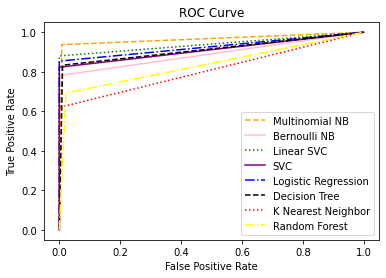

In [29]:
def roc_aucCurve(X, Y, testPrediction, classifier):
    spam_auc = roc_auc_score(testLabels, testPrediction)

    print(classifier, ' - Spam Messages: ROC AUC = %.3f' % (spam_auc))

    spamFalsePos, spamTruePos, _ = roc_curve(testLabels, testPrediction)
    return [spamFalsePos, spamTruePos]

res = roc_aucCurve(trainMessagesDF, trainLabels, mnbPrediction, 'Multinomial NB')
plt.plot(res[0], res[1], linestyle='--', color='orange', label='Multinomial NB')

res = roc_aucCurve(trainMessagesDF, trainLabels, bnbPrediction, 'Bernoulli NB')
plt.plot(res[0], res[1], linestyle='-', color='pink', label='Bernoulli NB')

res = roc_aucCurve(trainMessagesDF, trainLabels, linsvcPrediction, 'Linear SVC')
plt.plot(res[0], res[1], linestyle=':', color='green', label='Linear SVC')

res = roc_aucCurve(trainMessagesDF, trainLabels, svcPrediction, 'SVC (rbf Kernel)')
plt.plot(res[0], res[1], linestyle='-', color='purple', label='SVC')

res = roc_aucCurve(trainMessagesDF, trainLabels, logRegPrediction, 'Logistic Regression')
plt.plot(res[0], res[1], linestyle='dashdot', color='blue', label='Logistic Regression')

res = roc_aucCurve(trainMessagesDF, trainLabels, dtcPrediction, 'Decision Tree')
plt.plot(res[0], res[1], linestyle='--', color='black', label='Decision Tree')

res = roc_aucCurve(trainMessagesDF, trainLabels, kncPrediction, 'K Nearest Neighbor')
plt.plot(res[0], res[1], linestyle=':', color='red', label='K Nearest Neighbor')

res = roc_aucCurve(trainMessagesDF, trainLabels, rfPrediction, 'Random Forest')
plt.plot(res[0], res[1], linestyle='dashdot', color='yellow', label='Random Forest')

plt.title('ROC Curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')

plt.show()

In [30]:
# Ensemble Classifier (Voting Classifier)
votingCLF = VotingClassifier(estimators=[
    ('MNB', mnbModel), ('BNB', bnbModel), ('linearSVC', linsvcModel), ('SVC', svcModel), ('logReg', logRegModel), ('DTC', dtcModel), ('KNC', kncModel), ('RF', rfModel)
], voting='hard')

for clf, label in zip([mnbModel, bnbModel, linsvcModel, svcModel, logRegModel, dtcModel, kncModel, rfModel, votingCLF], ['Multinomial NB', 'Bernoulli NB', 'Linear SVC', 'SVC (rfb Kernel', 'Logistic Regression', 'Decision Tree', 'K Nearest Neighbor', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, trainMessagesDF, trainLabels, scoring='accuracy', cv=9)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.97 (+/- 0.01) [Multinomial NB]
Accuracy: 0.98 (+/- 0.00) [Bernoulli NB]
Accuracy: 0.98 (+/- 0.00) [Linear SVC]
Accuracy: 0.97 (+/- 0.01) [SVC (rfb Kernel]
Accuracy: 0.98 (+/- 0.00) [Logistic Regression]
Accuracy: 0.96 (+/- 0.01) [Decision Tree]
Accuracy: 0.95 (+/- 0.01) [K Nearest Neighbor]
Accuracy: 0.93 (+/- 0.01) [Random Forest]
Accuracy: 0.98 (+/- 0.01) [Ensemble]
